In [15]:
import sys
import os

CURRENT_DIR = os.path.dirname(os.path.realpath("__file__"))
BASE_DIR = os.path.join(CURRENT_DIR, os.pardir)
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")

sys.path.append(BASE_DIR)
sys.path.append(CURRENT_DIR)

from model.model import AdaptationModel, Wizard
from model import utils
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting

# sns.set_style()
# sns.set_theme(style = 'whitegrid', palette = 'deep')

plt.style.use("../model/myBmh.mplstyle")

In [16]:
# Utilities
from itertools import product, chain
import pandas as pd
import numpy as np


def calc_col_names(named_shape):
    *prefix, shape = named_shape
    names = [map(str, range(i)) for i in shape]
    return map('_'.join, product(prefix, *names))


def create_flat_columns_df_from_dict_of_numpy(
        named_np: dict[str, np.array],
        n_samples_per_np: int,
):
    flat_nps = [a.reshape(n_samples_per_np, -1) for a in named_np.values()]
    stacked_nps = np.column_stack(flat_nps)
    named_shapes = [(name, arr.shape[1:]) for name, arr in named_np.items()]
    col_names = [*chain.from_iterable(calc_col_names(named_shape) for named_shape in named_shapes)]
    df = pd.DataFrame(stacked_nps, columns=col_names)
    df = df.convert_dtypes()
    return df


    

In [17]:
## Load data

results = load_results(os.path.join(OUTPUT_DIR, "temporary.tar.gz"))
experiments, data = results

display(experiments)

unique_policies = experiments["policy"].unique()

n_scenarios = data["TotalAdapted"].shape[0]
n_replications = data["TotalAdapted"].shape[1]
n_timesteps = data["TotalAdapted"].shape[2]
n_policies = len(unique_policies)

n_metrics = len(list(data.keys()))

print(f"Analysing {n_scenarios} scenarios, with policies {list(unique_policies)}, {n_replications} replications, {n_timesteps} timesteps")

,initial_adaptation_cost,scenario,policy,model
0,176,0,Poor,AdaptationModel
1,23,1,Poor,AdaptationModel
2,129,2,Poor,AdaptationModel
3,67,3,Poor,AdaptationModel
4,111,4,Poor,AdaptationModel
5,176,0,Rich,AdaptationModel
6,23,1,Rich,AdaptationModel
7,129,2,Rich,AdaptationModel
8,67,3,Rich,AdaptationModel
9,111,4,Rich,AdaptationModel


Analysing 15 scenarios, with policies ['Poor', 'Rich', 'Richest'], 2 replications, 80 timesteps


In [18]:
avg_per_policy = {p: np.mean(data["TotalAdapted"][experiments["policy"] == p], axis=(0,1)) for p in unique_policies}

df_avg_per_policy = pd.DataFrame(avg_per_policy)
df_avg_per_policy

# sns.lineplot(data=df_avg_per_policy,hue="region",)


,Poor,Rich,Richest
0,0.0,0.0,0.0
1,0.0,3.5,17.5
2,0.0,5.1,22.6
3,0.0,5.7,24.8
4,0.0,7.4,26.8
...,...,...,...
75,0.5,14.0,33.3
76,0.5,14.0,33.4
77,0.5,14.0,33.4
78,0.5,14.0,33.4


In [19]:
# Usefull Dataframes
flat_dict=  {k: v.flatten() for k, v in data.items()}
df_all = pd.DataFrame(np.repeat(experiments.values, n_replications*n_timesteps, axis=0), columns=experiments.columns)
df_all["time"]= np.array([i for j in range(n_replications * n_scenarios)  for i in range(n_timesteps)])
df_all = df_all.join(pd.DataFrame(flat_dict))
df_all

# Mean of the scenarios
df_scenario_mean = df_all.groupby(["policy", "scenario", "time"])[["TotalAdapted"]].mean()



<Axes: xlabel='time', ylabel='TotalAdapted'>

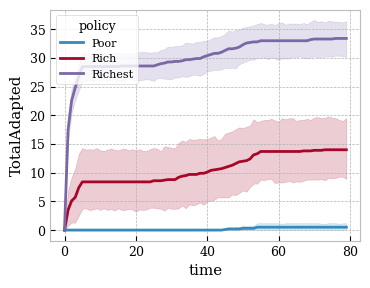

In [20]:
sns.lineplot(x="time", y="TotalAdapted", hue="policy", data=df_all)

<Axes: xlabel='policy', ylabel='TotalAdapted'>

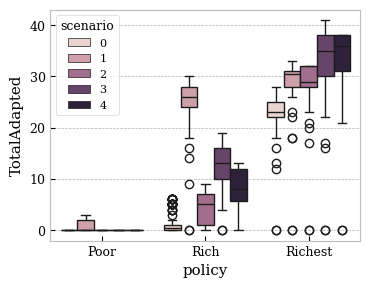

In [21]:
sns.boxplot(x="policy", y="TotalAdapted", hue="scenario", data=df_all)

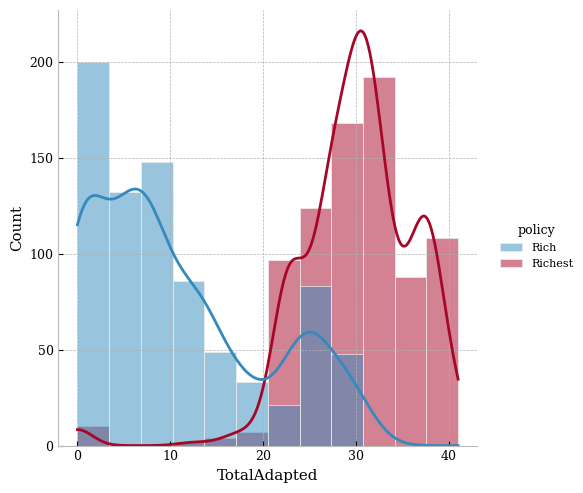

In [28]:
sns.displot(data=df_all[df_all["policy"]!="Poor"], x="TotalAdapted", hue="policy" , kde=True)


<Axes: xlabel='time', ylabel='TotalAdapted'>

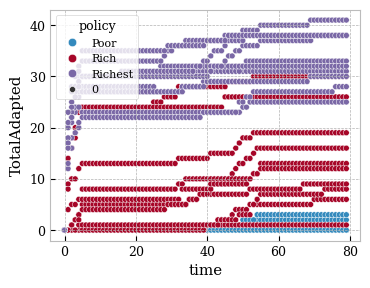

In [32]:
sns.scatterplot(data=df_all, x="time", y="TotalAdapted", hue="policy")